<a href="https://colab.research.google.com/github/17092003vamsi/213ECE3317/blob/main/SHAP_TRAIL_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Importing Necessary Libraries***

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
import os
!pip install shap
import shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 22.5 MB/s eta 0:00:00


**Loading the Dataset**

In [2]:
def load_data(file_path):
    data = pd.read_csv('COMPLETE DATA SET 2 (1).csv')
    return data


**Preprocessing the Data**

In [3]:
def preprocess_data(data):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data.iloc[:, -1].values)

    X = data.iloc[:, :-1]
    non_numeric_cols = X.select_dtypes(exclude=['number']).columns
    X = pd.get_dummies(X, columns=non_numeric_cols)

    X = X.values
    X_fft = np.abs(np.array([fft(signal) for signal in X]))
    X_fft = X_fft.reshape((X_fft.shape[0], X_fft.shape[1], 1))

    return X_fft, y


**Splitting the Data**

In [4]:
def split_data(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test


**Building the CNN Model**

In [5]:
def build_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


**Training the Model**

In [21]:
def train_model(model, X_train, y_train, X_val, y_val):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr])
    return history


**Evaluating the Model**

In [8]:
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    y_pred = (model.predict(X_test) > 0.5).astype("int64")
    cm = confusion_matrix(y_test, y_pred)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return cm


**Visualizing Results**

In [9]:
def plot_results(history, cm):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


**Model Explainability Using SHAP**

In [10]:
def explain_model(model, X_test):
    subset_size = 100
    X_test_subset = X_test[:subset_size]

    explainer = shap.DeepExplainer(model, X_test_subset)
    shap_values = explainer.shap_values(X_test_subset)

    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    shap_values_mean = np.mean(np.abs(shap_values), axis=0)

    shap.summary_plot(shap_values_mean, X_test_subset, plot_type="label")


**Main Function**

In [20]:
def main(file_path):
    data = load_data(file_path)
    X, y = preprocess_data(data)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    model = build_model((X_train.shape[1], 1))
    history = train_model(model, X_train, y_train, X_val, y_val)

    cm = evaluate_model(model, X_test, y_test)
    plot_results(history, cm)

    explain_model(model, X_test)


**Example Plotting Function**

In [19]:
def plot_example(data):
    if not isinstance(data, pd.DataFrame) or data.empty:
        print("Dataset is empty or not a DataFrame.")
        return

    plt.figure(figsize=(10, 6))

    x_column = data.columns[0]
    y_column = data.columns[1]

    plt.plot(data[x_column], data[y_column], linewidth=2)

    plt.title(f'{x_column} vs {y_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)

    plt.show()


**Running the Program**

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 800ms/step - accuracy: 0.5820 - loss: 0.8279 - val_accuracy: 0.5161 - val_loss: 12.3527 - learning_rate: 0.0010
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 735ms/step - accuracy: 0.8994 - loss: 0.2378 - val_accuracy: 0.5161 - val_loss: 7.5860 - learning_rate: 0.0010
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9293 - loss: 0.1789 - val_accuracy: 0.5161 - val_loss: 5.1049 - learning_rate: 0.0010
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 742ms/step - accuracy: 0.9571 - loss: 0.1612 - val_accuracy: 0.5161 - val_loss: 3.5645 - learning_rate: 0.0010
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9914 - loss: 0.0759 - val_accuracy: 0.5161 - val_loss: 2.5856 - learning_rate: 0.0010
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 745ms/step - accuracy: 0.9659 - loss: 0.1041 - val_accuracy: 0.5161 - val_loss: 1.9636 - learning_rate: 0.0010
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9760 - loss: 0.0548 - val_accuracy: 0.5161 - val_loss:

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 464ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.69        32
           1       1.00      0.03      0.06        30

    accuracy                           0.53        62
   macro avg       0.76      0.52      0.38        62
weighted avg       0.75      0.53      0.39        62



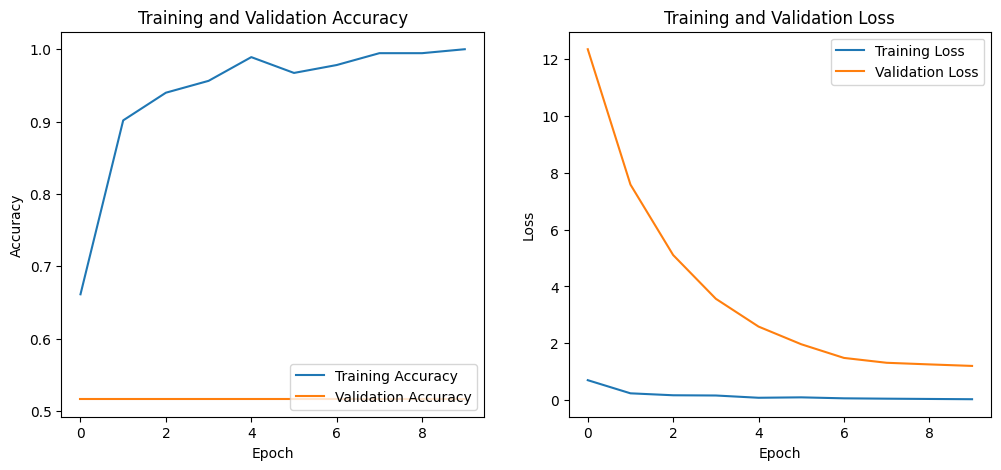

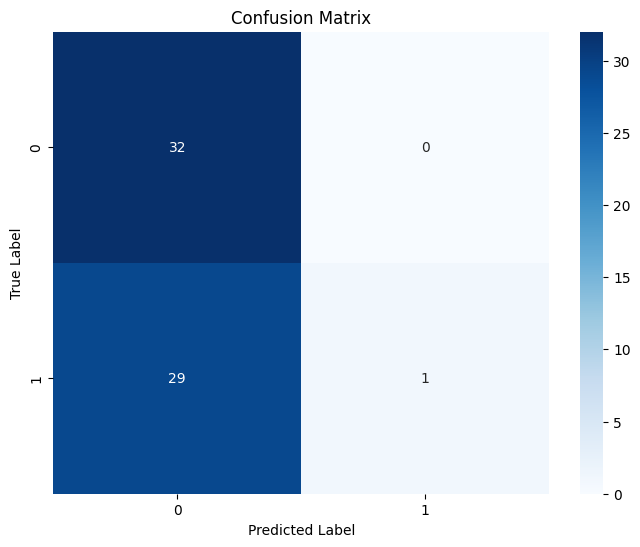

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [23]:
file_path = 'COMPLETE DATA SET 2 (1).csv'
main(file_path)

def main(file_path):
    df = pd.read_csv(file_path)
    df

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5688 - loss: 1.1271 - val_accuracy: 0.5161 - val_loss: 12.1470 - learning_rate: 0.0010
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 760ms/step - accuracy: 0.8427 - loss: 0.4040 - val_accuracy: 0.5161 - val_loss: 7.6069 - learning_rate: 0.0010
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 748ms/step - accuracy: 0.8813 - loss: 0.3148 - val_accuracy: 0.5161 - val_loss: 5.4215 - learning_rate: 0.0010
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 942ms/step - accuracy: 0.9514 - loss: 0.2138 - val_accuracy: 0.5161 - val_loss: 3.8356 - learning_rate: 0.0010
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 857ms/step - accuracy: 0.9581 - loss: 0.1565 - val_accuracy: 0.5161 - val_loss: 2.7630 - learning_rate: 0.0010
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 921ms/step - accuracy: 0.9526 - loss: 0.1374 - val_accuracy: 0.5161 - val_loss: 1.8686 - learning_rate: 0.0010
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 885ms/step - accuracy: 0.9831 - loss: 0.0947 - val_accuracy: 

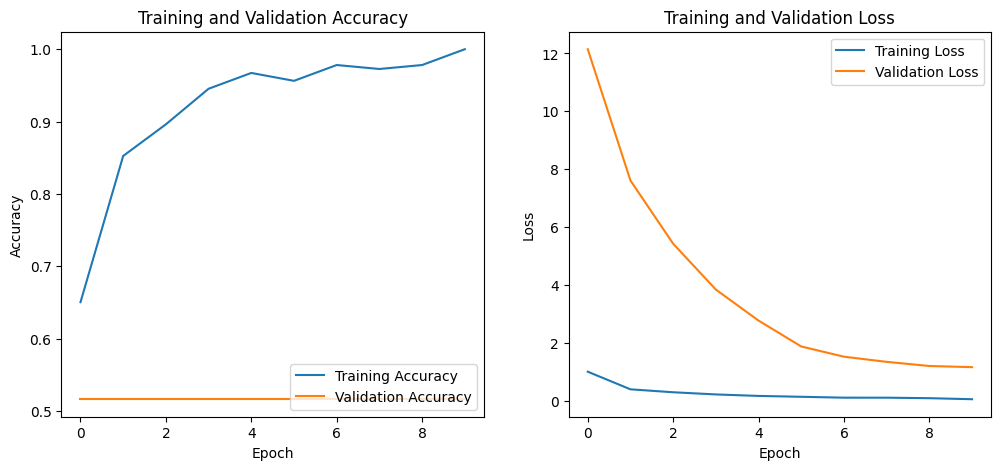

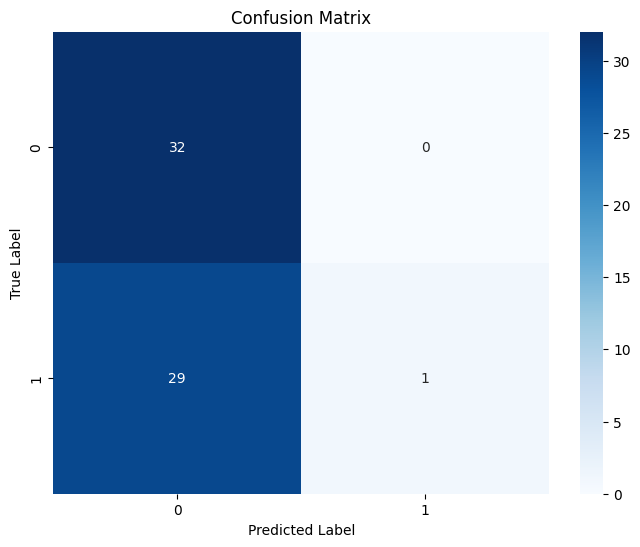

/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


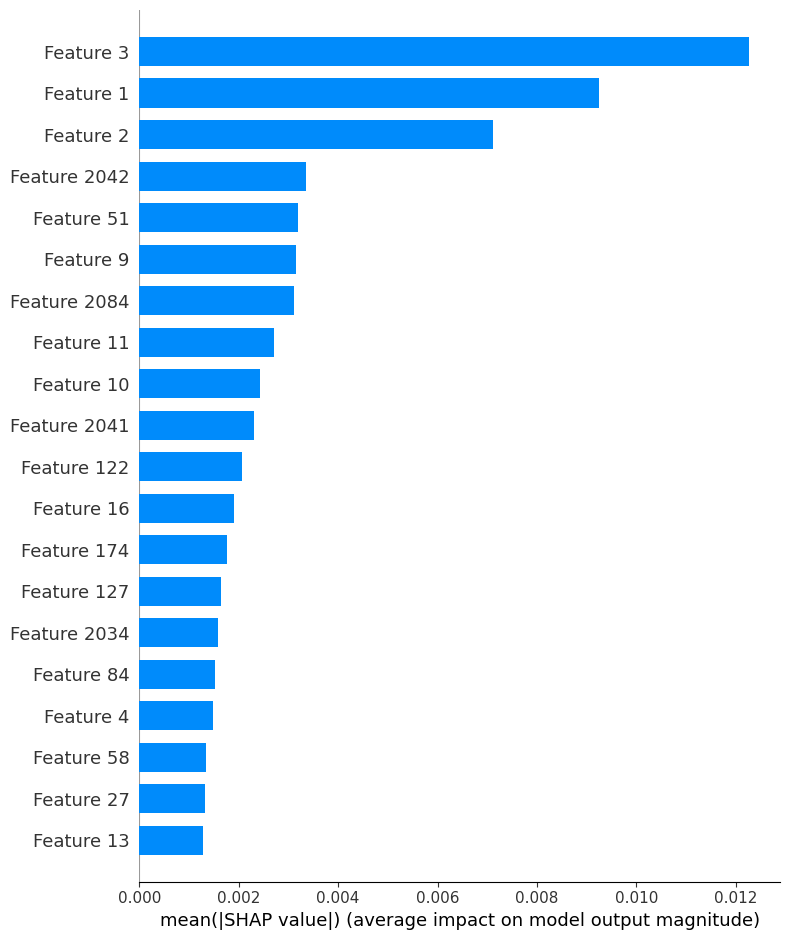

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
import shap

# Load the dataset
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Preprocess the data
def preprocess_data(data):
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(data.iloc[:, -1].values)

    # Identify non-numeric columns and apply one-hot encoding
    X = data.iloc[:, :-1]
    non_numeric_cols = X.select_dtypes(exclude=['number']).columns
    X = pd.get_dummies(X, columns=non_numeric_cols)

    # Apply FFT to each signal in the feature matrix
    X = X.values
    X_fft = np.abs(np.array([fft(signal) for signal in X]))

    # Reshape the feature matrix for CNN input
    X_fft = X_fft.reshape((X_fft.shape[0], X_fft.shape[1], 1))

    return X_fft, y

# Split the dataset into training, validation, and testing sets
def split_data(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Build the CNN model
def build_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Train the model with advanced callbacks
def train_model(model, X_train, y_train, X_val, y_val):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping, reduce_lr])
    return history

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Generate predictions and confusion matrix
    y_pred = (model.predict(X_test) > 0.5).astype("int64")
    cm = confusion_matrix(y_test, y_pred)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return cm

# Visualize results
def plot_results(history, cm):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# SHAP model explainability
def explain_model(model, X_test):
    # Select a smaller subset of test data for explanation
    subset_size = 100
    X_test_subset = X_test[:subset_size]

    # Ensure the SHAP explainer matches the input shape of the model
    explainer = shap.DeepExplainer(model, X_test_subset)
    shap_values = explainer.shap_values(X_test_subset)

    # Handle the case where shap_values is a list (for multi-output models)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]  # Select the first output's SHAP values

    # Reshape SHAP values to match the original input shape
    shap_values_reshaped = shap_values.reshape(shap_values.shape[0], -1)

    # Reshape X_test_subset for compatibility with summary_plot
    X_test_subset_reshaped = X_test_subset.reshape(X_test_subset.shape[0], -1)

    # Plot summary using SHAP mean absolute values
    shap.summary_plot(shap_values_reshaped, X_test_subset_reshaped, plot_type="bar")

# Main execution
def main():
    file_path = 'COMPLETE DATA SET 2 (1).csv'  # Path to the dataset
    data = load_data(file_path)
    X, y = preprocess_data(data)
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    model = build_model((X_train.shape[1], 1))
    history = train_model(model, X_train, y_train, X_val, y_val)

    cm = evaluate_model(model, X_test, y_test)
    plot_results(history, cm)

    explain_model(model, X_test)

# Run the main function
main()
